# Surprisingly aggressive treatments
This notebook generates the figures describing the heuristic in Figure 3a-b and computes the related statistics mentioned in the paper.

## Loading data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
data_prefix = ''
datapath = '<REPLACE WITH OUTPUT PATH>'
figpath = './figs'
import sys; sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import pickle as pkl
import shelve
import numpy as np
import pandas as pd
from trajectoryInspection import mimic_utils as utils
from trajectoryInspection.mimic_config import colbin, collog, colnorm, feature_vars_map
from trajectoryInspection import mdp_utils as cf

# Avoid Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import logging as log
import sys
log.basicConfig(stream=sys.stdout, level=log.DEBUG)
log.getLogger('matplotlib').setLevel(log.WARNING)

from tqdm import tqdm_notebook as tqdm

# Max number of time steps
N_HORIZON=20

# Number of simulated trajectories / real trajectory
NCFSAMPS=5

# Since we've already learned a policy, no discounting here
DISCOUNT=1.

# Number of actions
nact = 25
# Number of states (clusters)
ncl = 750
# Indices
death_state_idx = ncl
lives_state_idx = ncl+1

In [3]:
# Read-only access to the data
data_dict = shelve.open("{}/{}data_dict.db".format(datapath, data_prefix), flag='r')

In [4]:
best_results = data_dict['best_results']

In [5]:
traj_train = data_dict['best_results']['traj_train']
traj_test = data_dict['traj_test']
final_obs_b_soft = data_dict['best_results']['obs_b_soft']
final_rl_pol_soft = data_dict['best_results']['rl_pol_soft']
final_rl_pol = data_dict['best_results']['rl_pol']

## Identifying states to investigate under surprisingly aggressive treatments heuristic

In [6]:
state_counts = np.zeros(data_dict['best_results']['rl_pol'].shape[0], dtype=np.int32)
state_action_counts = np.zeros(data_dict['best_results']['rl_pol'].shape, dtype=np.int32)
train_actions = data_dict['best_results']['traj_train']['action_idx'].values
train_states = data_dict['best_results']['traj_train']['from_state_idx'].values
for idx in range(len(train_actions)):
    idx_state = train_states[idx]
    idx_action = train_actions[idx]
    state_counts[idx_state] += 1
    state_action_counts[idx_state,idx_action] += 1

In [7]:
rare_state_actions = []
for state_idx in range(data_dict['best_results']['rl_pol'].shape[0]):
    if state_counts[state_idx] < 100:
        continue
    state_action_idx = int(np.nonzero(data_dict['best_results']['rl_pol'][state_idx])[0])
    if state_action_counts[state_idx,state_action_idx] > 0 \
        and state_action_counts[state_idx,state_action_idx]/float(state_counts[state_idx]) <= 0.01:
        rare_state_actions.append((state_idx, state_action_idx))
print(len(rare_state_actions))
print(rare_state_actions)

15
[(62, 19), (91, 11), (121, 14), (181, 16), (205, 13), (312, 14), (339, 18), (436, 8), (438, 19), (543, 17), (660, 13), (672, 22), (673, 18), (696, 7), (711, 24)]


In [8]:
rare_state_largest_action = []
for idx in range(len(rare_state_actions)):
    state = rare_state_actions[idx][0]
    rare_state_largest_action.append((state, np.argmax(state_action_counts[state])))
print(rare_state_largest_action)

[(62, 10), (91, 10), (121, 5), (181, 20), (205, 10), (312, 5), (339, 10), (436, 10), (438, 15), (543, 20), (660, 15), (672, 5), (673, 20), (696, 0), (711, 15)]


## Generating Figure 3a

In [9]:
# percentage of time rl action happens
rl_percentages = []
for state_idx in range(data_dict['best_results']['rl_pol'].shape[0]):
    state_action_idx = int(np.nonzero(data_dict['best_results']['rl_pol'][state_idx])[0])
    rl_percentages.append(state_action_counts[state_idx,state_action_idx]/float(state_counts[state_idx]))

[[14]]


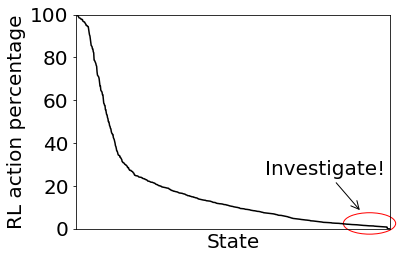

In [10]:
sorted_idxs = np.argsort(np.array(rl_percentages))
reverse_sorted_idxs = np.argsort(-1*np.array(rl_percentages))
sorted_rl_percentages = np.array(rl_percentages)[reverse_sorted_idxs.tolist()]
print(np.argwhere(sorted_idxs==672))
plt.rcParams.update({'font.size':20})
fig, ax = plt.subplots()
ax.plot(np.arange(len(sorted_rl_percentages)), 100*sorted_rl_percentages, color='k')
ax.set_ylim(bottom=0,top=100)
ax.set_xlim(left=0,right=len(sorted_rl_percentages))
ax.set_xticks([])
ax.set_xlabel('State')
ax.set_ylabel('RL action percentage')
from matplotlib.patches import Ellipse
circ = Ellipse((len(sorted_rl_percentages)-50,0.025*100), 125, .1*100, color='r', fill=False, clip_on=False)
ax.add_artist(circ)
ax.annotate("Investigate!", (len(sorted_rl_percentages)-70, 0.08*100), xytext=(len(sorted_rl_percentages)-300, 0.25*100), \
            arrowprops={'arrowstyle': '->'}, clip_on=False)
plt.tight_layout()
plt.show()

## Generating Figure 3b

In [11]:
states_ordered = sorted_idxs[5:15]
common_fluids_ordered = np.zeros(10)
rl_fluids_ordered = np.zeros(10)
common_vasopressor_ordered = np.zeros(10)
rl_vasopressor_ordered = np.zeros(10)
for idx in range(len(rare_state_actions)):
    if rare_state_actions[idx][0] not in states_ordered.tolist():
        continue
    ordered_idx = states_ordered.tolist().index(rare_state_actions[idx][0])
    common_fluids_ordered[ordered_idx] = int(rare_state_largest_action[idx][1]/5)
    rl_fluids_ordered[ordered_idx] = int(rare_state_actions[idx][1]/5)
    common_vasopressor_ordered[ordered_idx] = int(rare_state_largest_action[idx][1]%5)
    rl_vasopressor_ordered[ordered_idx] = int(rare_state_actions[idx][1]%5)

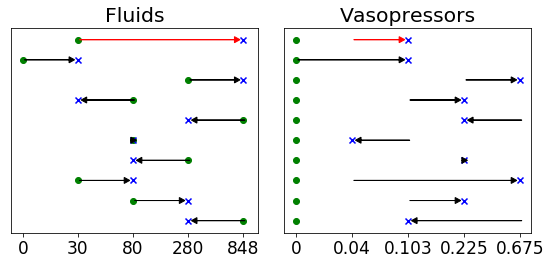

In [12]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True)
ax[0].scatter(common_fluids_ordered, range(1,len(common_fluids_ordered)+1), color='green')
ax[0].scatter(rl_fluids_ordered, range(1,len(rl_fluids_ordered)+1), color='blue', marker='x')
ax[1].scatter(common_vasopressor_ordered, range(1,len(common_vasopressor_ordered)+1), color='green')
ax[1].scatter(rl_vasopressor_ordered, range(1,len(rl_vasopressor_ordered)+1), color='blue', marker='x')
for idx in range(len(common_fluids_ordered)):
    color = 'black'
    if idx == 9:
        color = 'red'
    if rl_fluids_ordered[idx] > common_fluids_ordered[idx]:
        ax[0].arrow(common_fluids_ordered[idx]+0.03, idx+1, \
                    rl_fluids_ordered[idx] - common_fluids_ordered[idx] - 0.09, 0, \
                    head_width=0.3, head_length=0.1, length_includes_head=True, color=color)
    else:
        ax[0].arrow(common_fluids_ordered[idx]+0.03, idx+1, \
                    rl_fluids_ordered[idx] - common_fluids_ordered[idx] + 0.03, 0, \
                    head_width=0.3, head_length=0.1, length_includes_head=True, color=color)
    if rl_vasopressor_ordered[idx] > common_fluids_ordered[idx]:
        ax[1].arrow(common_fluids_ordered[idx]+0.03, idx+1, \
                    rl_vasopressor_ordered[idx] - common_fluids_ordered[idx] - 0.09, 0, \
                    head_width=0.3, head_length=0.1, length_includes_head=True, color=color)
    else:
        ax[1].arrow(common_fluids_ordered[idx]+0.03, idx+1, \
                    rl_vasopressor_ordered[idx] - common_fluids_ordered[idx] + 0.03, 0, \
                    head_width=0.3, head_length=0.1, length_includes_head=True, color=color)
ax[0].set_xticks(range(5))
ax[0].set_xticklabels([0,30,80,280,848])
ax[1].set_xticks(range(5))
ax[1].set_xticklabels([0,0.04,0.103,0.225,0.675])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_title('Fluids')
ax[1].set_title('Vasopressors')
plt.tight_layout()
plt.show()

## Compute statistics related to this heuristic

Quote from paper: The most common action performed by the clinicians for patients in this state was to provide 30cc of fluids[...] and no vasopressors. In contrast, the RL policy recommends 848cc of fluids and 0.13 micrograms/kg/min of vasopressors. Of the 632 times the state is observed in the training data, the common action noted above is taken 161 times, while the ‘optimal’ action according to the learned RL policy is chosen only 6 times by clinicians.

In [14]:
feature_lookup = data_dict['feature_lookup']
action_lookup = data_dict['action_lookup']
print('Number of state occurrences: ' + str(state_counts[672]))
print('Number of common action occurrences: ' + str(state_action_counts[672][5]))
print('Number of RL action occurrences: ' + str(state_action_counts[672][22]))
print('Common fluids dosage: ' + str(action_lookup['iol_median'].values[5]))
print('Common vasopressors dosage: ' + str(action_lookup['vcl_median'].values[5]))
print('RL fluids dosage: ' + str(action_lookup['iol_median'].values[22]))
print('RL vasopressors dosage: ' + str(action_lookup['vcl_median'].values[22]))

Number of state occurrences: 632
Number of common action occurrences: 161
Number of RL action occurrences: 6
Common fluids dosage: 30.0
Common vasopressors dosage: 0.0
RL fluids dosage: 848.147066666667
RL vasopressors dosage: 0.10300000000000001


Quote from paper: Among the training data, the RL action from the state analyzed for patient 1 was observed for only 6 patients (who survived), while the common action was observed for 148 patients who survived and 13 patients who died.

In [15]:
traj_train_reset_index = traj_train.reset_index()
states = traj_train_reset_index['from_state_idx'].values
actions = traj_train_reset_index['action_idx'].values
blocs = traj_train_reset_index['bloc'].values
icustayids = traj_train_reset_index['icustayid'].values
a5_rewards = []
a22_rewards = []
for idx in range(len(states)):
    if states[idx] == 672:
        if actions[idx] == 5:
            reward = traj_train_reset_index.loc[traj_train_reset_index['icustayid']==icustayids[idx]].reward.values[-1]
            a5_rewards.append(reward)
        elif actions[idx] == 22:
            reward = traj_train_reset_index.loc[traj_train_reset_index['icustayid']==icustayids[idx]].reward.values[-1]
            a22_rewards.append(reward)

In [16]:
print(np.unique(np.array(a5_rewards), return_counts=True))
print(np.unique(np.array(a22_rewards), return_counts=True))

(array([-100,  100]), array([ 13, 148]))
(array([100]), array([6]))


Quote from paper: Among the 100 states where [the RL action] proportion was smallest, the RL action is observed 1.5% of the time on average (6.4 observations per state), while the action most frequently chosen by clinicians is observed 35.7% of the time on average (154.5 observations per state). These states collectively make up 26.2% of the transitions in the training data, a nontrivial fraction.

In [17]:
def calc_state_occurrence_proportion(top_num):
    sorted_idxs = np.argsort(np.array(rl_percentages))
    top_idxs = sorted_idxs[5:5+top_num]
    total_state_count = 0
    for idx in top_idxs:
        total_state_count += state_counts[idx]
    print(total_state_count/float(np.sum(state_counts)))

In [18]:
def calc_rl_common_avg_count(top_num):
    sorted_idxs = np.argsort(np.array(rl_percentages))
    top_idxs = sorted_idxs[5:5+top_num]
    total_rl_count = 0
    total_common_count = 0
    counts = np.empty(top_num)
    j = 0
    for idx in top_idxs:
        counts[j] = state_action_counts[idx,int(np.nonzero(final_rl_pol[idx])[0])]
        j+=1
        total_rl_count += state_action_counts[idx,int(np.nonzero(final_rl_pol[idx])[0])]
        total_common_count += np.max(state_action_counts[idx])
    print(total_rl_count/float(top_num))
    print(total_common_count/float(top_num))
    print(np.unique(counts,return_counts=True))

In [19]:
def calc_rl_common_avg_perc(top_num):
    sorted_idxs = np.argsort(np.array(rl_percentages))
    top_idxs = sorted_idxs[5:5+top_num]
    rl_percs = np.empty(top_num)
    common_percs = np.empty(top_num)
    j = 0
    for idx in top_idxs:
        rl_percs[j] = state_action_counts[idx,int(np.nonzero(final_rl_pol[idx])[0])]/float(state_counts[idx])
        common_percs[j] = np.max(state_action_counts[idx])/float(state_counts[idx])
        j+=1
    print(np.average(rl_percs))
    print(np.average(common_percs))

In [20]:
calc_state_occurrence_proportion(100)
calc_rl_common_avg_perc(100)
calc_rl_common_avg_count(100)

0.2618368953344147
0.015110765686679278
0.35676111247297115
6.35
154.47
(array([ 5.,  6.,  7.,  8.,  9., 10., 11., 13., 14.]), array([44, 21, 16,  7,  7,  2,  1,  1,  1]))


Quote from paper: For 99 of these 100 states, common practice involves zero vasopressors. Yet, the RL policy recommends vasopressors in 87 of those states, with 49 of those recommendations being large doses, which we define as those in the upper 50th percentile of nonzero amounts.

In [23]:
sorted_idxs = np.argsort(np.array(rl_percentages))
top_idxs = sorted_idxs[5:105]
common_vasopressor_counts = np.zeros(5,dtype=np.int32)
rl_vasopressor_counts = np.zeros(5,dtype=np.int32)
for idx in top_idxs:
    rl_action = int(np.nonzero(final_rl_pol[idx])[0])
    common_action = np.argmax(state_action_counts[idx])
    common_vasopressor_counts[int(common_action%5)] += 1
    if common_action%5 == 0:
        rl_vasopressor_counts[int(rl_action%5)] += 1
print(common_vasopressor_counts)
print(rl_vasopressor_counts)

[99  0  0  0  1]
[12 21 17 27 22]
